# California Housing Prices

A model of housing prices in the state. The model should predict median housing price in any district, given all the metrics.

## 0. Framing the problem

* Supervised Learning (the data is labeled)
* Regression Task (predict median housing price)
    * Multiple regression (the data has multiples features)
    * Univariate regression (Single prediction for each entry)
    * plain batch learning (there is no data streaming or a big data problem)

### 0.1. Performance Measure
$$RMSE(X, h)=\sqrt{\frac{1}{m}\sum_{i=1}^m(h(X^i)-y^i)^2}$$

if the data has many outliers the $ RMSE $ is penalized because it is squared. In this case, $ MAE $ may be more suitable. 
$$MAE(X, h)=\frac{1}{m}\sum_{i=1}^m|h(X^i)-y^i|$$

## 1. Imports

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew, t, sem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OneHotEncoder, StandardScaler
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.linear_model    import LinearRegression
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics         import mean_squared_error
from xgboost import XGBRegressor

## 2. Getting the data

In [50]:
download_root = "https://raw.githubusercontent.com/caiomts/handson-ml2/master/datasets/housing/housing.csv"

In [51]:
data = pd.read_csv(download_root)

In [52]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 3. Exploring the data structure

In [54]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [55]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

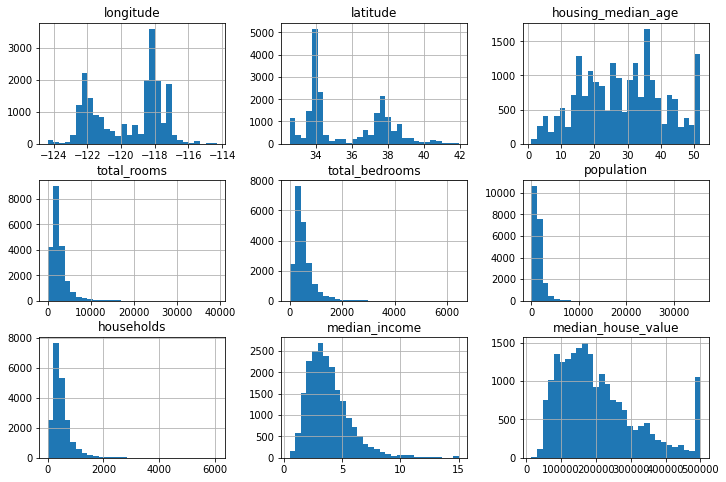

In [56]:
data.hist(bins=30, figsize=(12, 8))

* median_income is preprocessed, scaled and capped [0.5, 15]
* median_house_value is capped in 500,000
* housing_median_age is capped in 50

/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='median_house_value', ylabel='Density'>

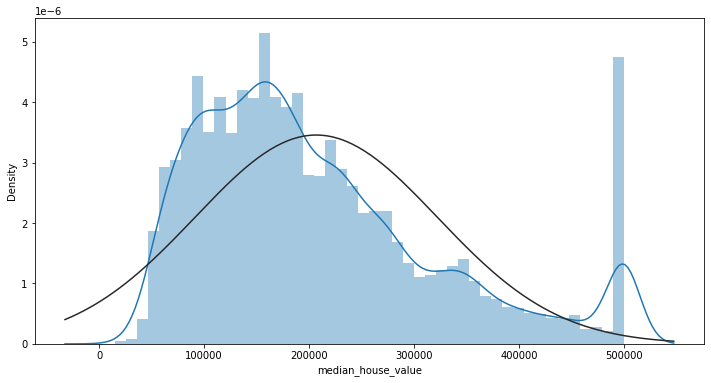

In [57]:
plt.figure(figsize=(12,6))
sns.distplot(data['median_house_value'] , fit=norm)

<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>

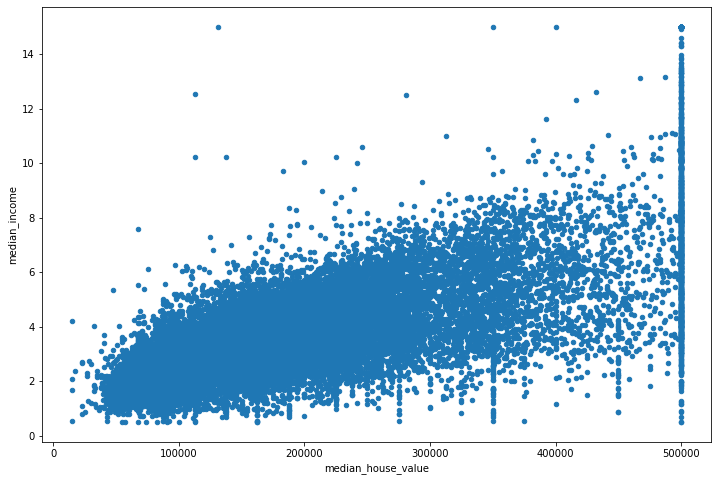

In [58]:
data.plot(kind='scatter', x='median_house_value', y='median_income', figsize=(12, 8))

/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='median_income', ylabel='Density'>

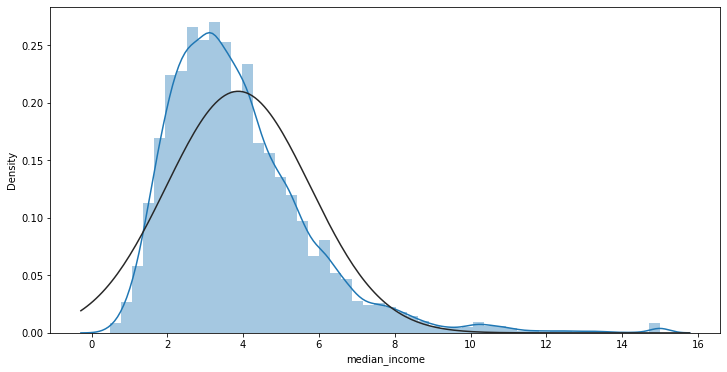

In [59]:
plt.figure(figsize=(12,6))
sns.distplot(data['median_income'] , fit=norm)

## 4. Test Set

In [60]:
# avoiding sampling bias - stratified sampling
housing = data.copy()
housing['income_cat'] = pd.cut(housing['median_income'], bins=5)

In [61]:
housing['income_cat'].value_counts()

(0.485, 3.4]    9683
(3.4, 6.3]      9088
(6.3, 9.2]      1488
(9.2, 12.1]      271
(12.1, 15.0]     110
Name: income_cat, dtype: int64

In [62]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(housing, housing['income_cat']):
    train = housing.loc[train_index]
    test = housing.loc[test_index]

In [63]:
# drop income_cat
for data in (train, test):
    data.drop('income_cat', axis=1, inplace=True)

## 5. Exploring and Analysing the data (EDA)

In [64]:
housing = train.copy()

### 5.1. Taking a look at geographical data

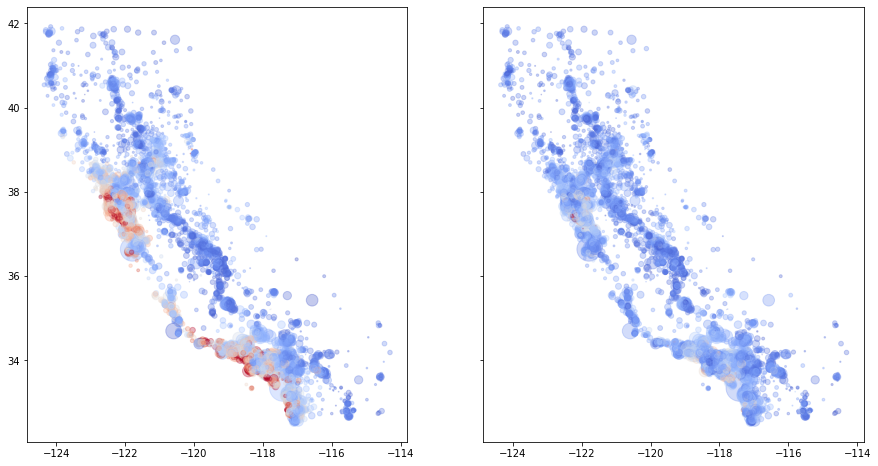

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 8))

ax[0].scatter(data= housing, x='longitude', y='latitude', alpha=0.3, 
              s=housing.population/50, label='population',
              c='median_house_value', cmap=plt.get_cmap('coolwarm'))

ax[1].scatter(data= housing, x='longitude', y='latitude', alpha=0.3,
                    s=housing.population/50, label='population',
                    c='median_income', cmap=plt.get_cmap('coolwarm'))

Housing prices are related to the location as well as to the population density and median income

### 5.2. Correlations

In [66]:
corr = housing.corr()
corr.sort_values(by=['median_house_value'], ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
median_house_value,-0.049171,-0.143003,0.105963,0.134639,0.050426,-0.024760,0.066241,0.687750,1.000000
median_income,-0.018155,-0.077613,-0.116162,0.199191,-0.007480,0.005928,0.013836,1.000000,0.687750
total_rooms,0.043453,-0.036126,-0.357519,1.000000,0.929992,0.853380,0.918674,0.199191,0.134639
housing_median_age,-0.105912,0.007988,1.000000,-0.357519,-0.318403,-0.289969,-0.300555,-0.116162,0.105963
households,0.053271,-0.070518,-0.300555,0.918674,0.979652,0.904492,1.000000,0.013836,0.066241
total_bedrooms,0.068522,-0.067368,-0.318403,0.929992,1.000000,0.874536,0.979652,-0.007480,0.050426
population,0.096979,-0.106862,-0.289969,0.853380,0.874536,1.000000,0.904492,0.005928,-0.024760
longitude,1.000000,-0.923948,-0.105912,0.043453,0.068522,0.096979,0.053271,-0.018155,-0.049171
latitude,-0.923948,1.000000,0.007988,-0.036126,-0.067368,-0.106862,-0.070518,-0.077613,-0.143003


<AxesSubplot:>

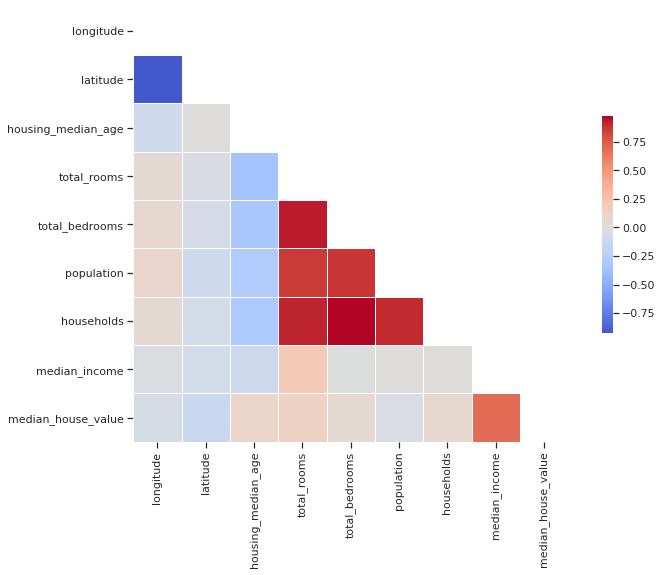

In [85]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=plt.get_cmap('coolwarm'), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

median_income is highly positively correlated with the target value. latitude is the second most correlated, but is negatively. More distance from the ocean the median value decreases. 
Household is highly correlated with total_room, total_bedroom and population. total_room with total bedroom

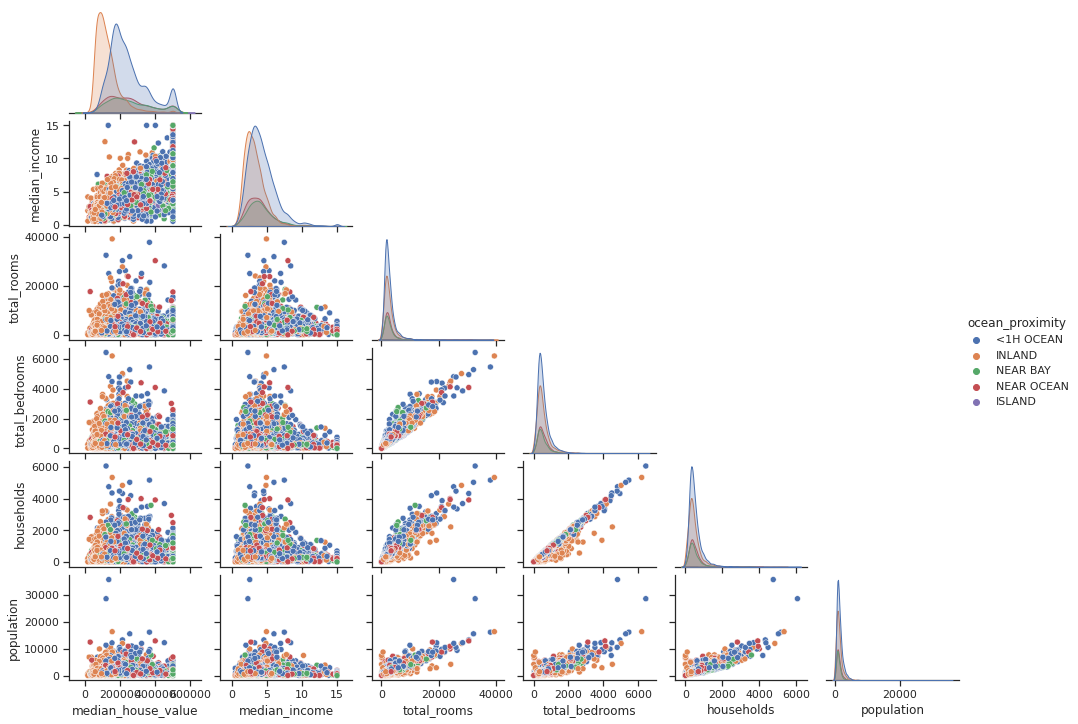

In [68]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'total_bedrooms',
              'households', 'population', 'ocean_proximity']

sns.set_theme(style="ticks")
g = sns.pairplot(housing[attributes], hue='ocean_proximity', corner=True)
g.fig.set_size_inches(15, 10)

In [69]:
housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)
skewed = housing.loc[:, housing.columns != 'ocean_proximity'].apply(skew).sort_values(ascending=False)
skewed

population            5.330596
total_rooms           4.204341
total_bedrooms        3.391854
households            3.351465
median_income         1.650456
median_house_value    0.980234
latitude              0.455123
housing_median_age    0.068404
longitude            -0.283194
dtype: float64

In [70]:
def log_skew(df, skew_num:float):
    skewed = df.apply(skew)
    for var in skewed[(skewed > skew_num) | (skewed < -skew_num)].index:
        df[var] = np.log1p(df[var])
    return df

log_housing = housing.drop(['ocean_proximity'], axis=1)

log_housing = log_skew(log_housing, 0.5)

In [71]:
log_housing.corr().sort_values(by=['median_house_value'], ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
median_house_value,-0.026152,-0.191782,0.074812,0.180823,0.082451,0.021188,0.107556,0.680546,1.000000
median_income,-0.019104,-0.082913,-0.135321,0.245194,0.008806,0.027908,0.041506,1.000000,0.680546
total_rooms,0.029289,-0.032662,-0.310455,1.000000,0.941520,0.865140,0.932541,0.245194,0.180823
households,0.053953,-0.086588,-0.238410,0.932541,0.970315,0.931145,1.000000,0.041506,0.107556
total_bedrooms,0.060268,-0.068359,-0.266319,0.941520,1.000000,0.892795,0.970315,0.008806,0.082451
housing_median_age,-0.105912,0.007988,1.000000,-0.310455,-0.266319,-0.238256,-0.238410,-0.135321,0.074812
population,0.106483,-0.133147,-0.238256,0.865140,0.892795,1.000000,0.931145,0.027908,0.021188
longitude,1.000000,-0.923948,-0.105912,0.029289,0.060268,0.106483,0.053953,-0.019104,-0.026152
latitude,-0.923948,1.000000,0.007988,-0.032662,-0.068359,-0.133147,-0.086588,-0.082913,-0.191782


In [72]:
corr.sort_values(by=['median_house_value'], ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
median_house_value,-0.049171,-0.143003,0.105963,0.134639,0.050426,-0.024760,0.066241,0.687750,1.000000
median_income,-0.018155,-0.077613,-0.116162,0.199191,-0.007480,0.005928,0.013836,1.000000,0.687750
total_rooms,0.043453,-0.036126,-0.357519,1.000000,0.929992,0.853380,0.918674,0.199191,0.134639
housing_median_age,-0.105912,0.007988,1.000000,-0.357519,-0.318403,-0.289969,-0.300555,-0.116162,0.105963
households,0.053271,-0.070518,-0.300555,0.918674,0.979652,0.904492,1.000000,0.013836,0.066241
total_bedrooms,0.068522,-0.067368,-0.318403,0.929992,1.000000,0.874536,0.979652,-0.007480,0.050426
population,0.096979,-0.106862,-0.289969,0.853380,0.874536,1.000000,0.904492,0.005928,-0.024760
longitude,1.000000,-0.923948,-0.105912,0.043453,0.068522,0.096979,0.053271,-0.018155,-0.049171
latitude,-0.923948,1.000000,0.007988,-0.036126,-0.067368,-0.106862,-0.070518,-0.077613,-0.143003


Log does not improve correlations much.

### 5.2. Trying some variables combinations

* households and total_bedrooms are highly correlated. Trying total_bedrooms_per_households
* total_rooms and total_bedrooms are highly correlated. Trying ratio bedrooms_per_total_rooms
* households and population are highly correlated. Trying ratio population_per_households

In [73]:
housing['households_per_bedroom'] = housing['households'] / housing['total_bedrooms']
housing['ratio_bedrooms_rooms'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_households'] = housing['households'] / housing['population']

In [74]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.687750
population_per_households    0.261327
total_rooms                  0.134639
housing_median_age           0.105963
households_per_bedroom       0.078861
households                   0.066241
total_bedrooms               0.050103
population                  -0.024760
longitude                   -0.049171
latitude                    -0.143003
ratio_bedrooms_rooms        -0.226178
Name: median_house_value, dtype: float64

 All new variables are more correlated than the originals.

### 6. Preparing data for ML 

In [75]:
X = train.drop(['median_house_value'], axis=1)
y = train['median_house_value'].copy()

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 18586 to 14289
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16349 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [77]:
class AttributeTransform(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        households_per_bedroom = X[:, 6] / X[:, 4]
        ratio_bedrooms_per_rooms = X[:, 4] / X[:, 3]
        pop_per_households = X[:, 6] / X[:, 5]
        X = np.delete(X, [4, 5, 6], axis=1)
        return np.c_[X, households_per_bedroom, ratio_bedrooms_per_rooms, pop_per_households]        

In [78]:

# numerical
num_attribs = list(X.loc[:,list(X.dtypes != 'object')].columns)
# categorical
cat_attribs = list(X.loc[:,list(X.dtypes == 'object')].columns)
# numerical pipeline
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='median')),
('attribs_trans', AttributeTransform()),
('std_scaler', StandardScaler())
])
# full pipe
full_pipeline = ColumnTransformer([
('num', num_pipeline, num_attribs),
('cat', OneHotEncoder(), cat_attribs)
])

X_prepared = full_pipeline.fit_transform(X)    

## 7. Selecting and Training Models
* Linear Regression
* Decison Tree
* Random Forest
* XGBoost

In [188]:
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor(random_state=0)
random_model = RandomForestRegressor(random_state=0)
gb_model = GradientBoostingRegressor(random_state=0)
xgb_model = XGBRegressor(random_state=0)

models = [linear_model, tree_model, random_model, gb_model, xgb_model]

# fitting the models
for model in models:
    model.fit(X_prepared, y)

In [189]:
# Predictions
predictions = []
for model in models:
    predictions.append(model.predict(X_prepared))

In [190]:
# RMSE
for prediction in predictions:
    print(mean_squared_error(y, prediction, squared=False))

65740.43967772493
0.0
18641.510711414474
50547.95542185541
27639.42626501808


linear model underfit the data and decision tree overfit the data.

### 7.1. Cross validation for better evaluation of models

In [191]:
for model in models:
    neg_scores = cross_val_score(model, X_prepared, y, cv=10, scoring='neg_mean_squared_error')
    scores = np.sqrt(-neg_scores)
    print(f'{model.__class__.__name__}\nScores: {scores}\nMean: {scores.mean()}\nsd: {scores.std()}')

LinearRegression
Scores: [64283.7956067  68964.88705961 68411.2423522  65679.93390062
 64615.5350763  65352.01242565 66248.01725023 65179.80014737
 63043.67819908 67073.39182007]
Mean: 65885.22938378261
sd: 1745.9553776499324
DecisionTreeRegressor
Scores: [72332.73437996 75938.56394877 72058.24515472 71024.52113509
 71289.59288236 68404.99120211 65610.7112312  69276.5701024
 68602.68975383 72823.74210033]
Mean: 70736.2361890775
sd: 2729.39692655012
RandomForestRegressor
Scores: [48483.83340304 52956.82056919 51099.32858053 50471.18576869
 49797.10745882 48091.57766958 50352.59928686 48637.34947213
 49774.68705038 51019.06517768]
Mean: 50068.35544369018
sd: 1384.882932677369
GradientBoostingRegressor
Scores: [52130.71838954 56436.43194556 54692.84489731 52954.15109865
 52194.20192223 51594.98415061 53858.06060968 51547.20696492
 52103.86278487 53360.93125123]
Mean: 53087.33940146064
sd: 1475.1219698953064
XGBRegressor
Scores: [45375.14399113 49656.42681355 47704.83794617 46315.43736537


## 8. Tuning the model

In [195]:
distributions = [{'n_estimators': np.arange(10, 400, 10),
                  'max_depth': np.arange(2, 30, 2),
                  'learning_rate': np.arange(0.01, 0.8, 0.005),
                  'booster': ['gbtree']
                 },
                 {'n_estimators': np.arange(10, 400, 10),
                  'max_depth': np.arange(2, 30, 2),
                  'learning_rate': np.arange(0.01, 0.8, 0.005),
                  'booster': ['gblinear']
                 },
                 {'n_estimators': np.arange(10, 400, 10),
                  'max_depth': np.arange(2, 30, 2),
                  'learning_rate': np.arange(0.01, 0.8, 0.005),
                  'booster': ['dart']
                 }]
grid_search = RandomizedSearchCV(xgb_model, distributions, n_iter=20, 
                                 scoring='neg_mean_squared_error', 
                                 return_train_score=True, random_state=0)
grid_search.fit(X_prepared, y)

[15:28:25] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:25] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

[15:28:48] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:48] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

[15:32:27] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:27] WARNING: ../src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

RandomizedSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_parallel...
       0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765, 0.77 ,
       0.775, 0.78 , 0.785, 0.79 , 0.795]),
                                         'max_depth':

In [196]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

47608.86108941179 {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.25499999999999995, 'booster': 'dart'}
53748.664796466175 {'n_estimators': 50, 'max_depth': 24, 'learning_rate': 0.40499999999999997, 'booster': 'gbtree'}
55531.73677890408 {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.019999999999999997, 'booster': 'dart'}
82302.47244267211 {'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.3, 'booster': 'gblinear'}
50073.22569760574 {'n_estimators': 210, 'max_depth': 4, 'learning_rate': 0.049999999999999996, 'booster': 'dart'}
82302.47175832909 {'n_estimators': 210, 'max_depth': 28, 'learning_rate': 0.6099999999999999, 'booster': 'gblinear'}
82302.47800086044 {'n_estimators': 390, 'max_depth': 20, 'learning_rate': 0.09499999999999999, 'booster': 'gblinear'}
82302.47677911445 {'n_estimators': 230, 'max_depth': 24, 'learning_rate': 0.10999999999999997, 'booster': 'gblinear'}
53983.19728838305 {'n_estimators': 300, 'max_depth': 26, 'learning_rate': 0.3899999999999

In [201]:
parameters = [{'n_estimators': np.arange(90, 140, 10),
                  'max_depth': np.arange(2, 6, 2),
                  'learning_rate': np.arange(0.2, 0.3, 0.02),
                  'booster': ['dart']
                 },
                 {'n_estimators': np.arange(60, 110, 10),
                  'max_depth': np.arange(8, 16, 2),
                  'learning_rate': np.arange(0.1, 0.2, 0.02),
                  'booster': ['gbtree']
                 }]

grid_search_2 = GridSearchCV(xgb_model, parameters, scoring='neg_mean_squared_error', 
                                 return_train_score=True)

grid_search_2.fit(X_prepared, y)

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=...
             param_grid=[{'booster': ['dart'],
                          'learning_rate': array([0.2 , 0.22, 0.24, 0.26, 0.28]),
                          'max_depth': array([2, 4]),
                          'n_estimators': array([ 90, 100, 110, 120, 130])},
                         {'booster': ['gbtree

In [202]:
cvres = grid_search_2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

54810.308323508005 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 90}
54379.346649427534 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
53997.41421177719 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 110}
53624.667723225466 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 120}
53286.748854992584 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 130}
48549.79689713432 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 90}
48208.66552806316 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
47982.60751000786 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 110}
47827.68177486491 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 120}
47589.262172742856 {'booster': 'dart', 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 130}
54350.458829037874 {'booste

In [203]:
grid_search_2.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.18000000000000002, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [205]:
parameters = [{'n_estimators': np.arange(90, 110, 5),
                  'max_depth': np.arange(6, 9, 1),
                  'learning_rate': np.arange(0.17, 0.19, 0.01),
                  'booster': ['gbtree']
                 }]

grid_search_3 = GridSearchCV(xgb_model, parameters, scoring='neg_mean_squared_error', 
                                 return_train_score=True)

grid_search_3.fit(X_prepared, y)

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             param_grid=[

In [207]:
cvres = grid_search_3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

47045.67434179026 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 90}
46969.29803974032 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 95}
46887.7315064995 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 100}
46819.93898228924 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 105}
46496.76977631333 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 7, 'n_estimators': 90}
46420.588239743505 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 7, 'n_estimators': 95}
46374.72075792665 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 7, 'n_estimators': 100}
46347.78125606008 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 7, 'n_estimators': 105}
46796.672187342825 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 8, 'n_estimators': 90}
46731.304003330595 {'booster': 'gbtree', 'learning_rate': 0.17, 'max_depth': 8, 'n_estimators': 95}
4671

## 9. Analyzing the fitted model

In [209]:
feature_importances = grid_search_3.best_estimator_.feature_importances_

In [213]:
extra_attribs = ['households_per_bedroom', 'ratio_bedrooms_per_rooms', 'pop_per_households']
num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms ', 'median_income']
cat_one_hot_attribs = ['<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.6300545, 'NEAR OCEAN'),
 (0.1775789, 'median_income'),
 (0.044116866, 'pop_per_households'),
 (0.03074258, 'ISLAND'),
 (0.020128408, 'housing_median_age'),
 (0.01984641, 'latitude'),
 (0.016599689, 'longitude'),
 (0.009144973, 'ratio_bedrooms_per_rooms'),
 (0.0085421335, 'households_per_bedroom'),
 (0.008182904, '<1H OCEAN'),
 (0.007653718, 'total_rooms '),
 (0.0, 'NEAR BAY')]

## 10. Evaluating the model on test set 

In [228]:
final_model = grid_search_3.best_estimator_

X_test = test.drop('median_house_value', axis =1)
y_test = test['median_house_value'].copy()

In [229]:
X_test_prepared = full_pipeline.transform(X_test)

In [230]:
final_predictions = final_model.predict(X_test_prepared)

In [231]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

### 10.1 Confidential Interval

In [236]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), 
                   scale=sem(squared_errors)))

array([44411.75264689, 48864.89660686])